In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pylab as pl
import xlrd

import math
import os
import re

from numba import njit
from numba import prange
import plotly

plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go

In [2]:
sns.set(rc={'figure.figsize': (9,6)})

In [3]:
colours_ = ['blue', 'orange', 'green', 'red', 'mediumpurple', 'black', 'brown', 'gray']
#colours_ = ['mediumpurple', 'mediumpurple', 'blue', 'blue', 'mediumpurple', 'black', 'brown', 'gray']
# colours_ = ['blue', 'orange', 'green', 'red', 'mediumpurple', 'black', 'brown', 'gray']
markers_ = ['-', '-', '-', '-', '-']
# markers_ = ['-', '.', '*', 'd', '.-', '^', 'v', 'o']
linestyle = ['-', '-.', '-*', ':', '--', '-o', '-d', '-x']

In [4]:
#В данном списке содержатся величины выходных радиусов исследуемых волок
R1 = [(0.412) / 2, (0.738) / 2, (2.23) / 2]
R0 = [(0.420) / 2, (0.771) / 2, (2.45) / 2]

D1 = [(0.412) / 1000, (0.738) / 1000, (2.23) / 1000]

In [4]:
R0 = 0.036

In [5]:
def read_data_txt_np(name_of_file, example_dir):
    content = os.listdir(example_dir)
    if os.path.isfile(os.path.join(example_dir, name_of_file)):
        file = os.path.join(example_dir, name_of_file)
        if file.endswith('.txt'):
            # data = np.loadtxt(file, dtype='double', skiprows=56) #thermal
            data = np.loadtxt(file, dtype='double', skiprows=44) #isothermal

    return data

In [6]:
def median_np(x):
    """ Построение медианы по переданному списку """
    return np.median(x)

In [7]:
#@njit(parallel=True)
def preprocessing_res_np(file):
    x_1 = (file[::, 1]) * 10 ** 3
    y_1 = (file[::, 2]) * 10 ** 3

    eps_11_name = file[::, 11]
    eps_22_name = file[::, 12]
    eps_33_name = file[::, 13]
    eps_12_name = file[::, 14]

    stress_11_name = (file[::, 3]) / 10 ** 6
    stress_22_name = (file[::, 4]) / 10 ** 6
    stress_33_name = (file[::, 5]) / 10 ** 6
    stress_12_name = (file[::, 6]) / 10 ** 6

    #nt11_name = (file[::,15])
    #temp_name = (file[::,16])

    index = 0

    x_1_ = np.zeros((1, 1))
    y_1_ = np.zeros((1, 1))
    Strain = np.zeros((1, 5))
    Stress = np.zeros((1, 5))
    #NT11 = np.zeros((1, 1))
    #TEMP = np.zeros((1, 1))
    #ind_ = np.zeros((1,1))
    for j in range(0, np.shape(y_1)[0]):
        if y_1[j] >= 0.25 * (np.max(y_1) - np.min(y_1)) and y_1[j] <= 0.75 * (np.max(y_1) - np.min(y_1)):
            x_1_[index] = x_1[j]
            y_1_[index] = y_1[j]
            #ind_[index] = j

            Stress[index, 0] = stress_11_name[j]
            Stress[index, 1] = stress_22_name[j]
            Stress[index, 2] = stress_33_name[j]
            Stress[index, 3] = stress_12_name[j]
            Stress[index, 4] = (1 / (np.sqrt(2))) * np.sqrt(
                (stress_11_name[j] - stress_22_name[j]) ** 2 + (stress_22_name[j] - stress_33_name[j]) ** 2 + (
                        stress_33_name[j] - stress_11_name[j]) ** 2 + 6 * (stress_12_name[j] ** 2))

            Strain[index, 0] = eps_11_name[j]
            Strain[index, 1] = eps_22_name[j]
            Strain[index, 2] = eps_33_name[j]
            Strain[index, 3] = eps_12_name[j]
            Strain[index, 4] = (1 / (np.sqrt(2))) * np.sqrt(
                (eps_11_name[j] - eps_22_name[j]) ** 2 + (eps_22_name[j] - eps_33_name[j]) ** 2 + (
                        eps_33_name[j] - eps_11_name[j]) ** 2 + 6 * (eps_12_name[j] ** 2))

            #NT11[index]=nt11_name[j]
            #TEMP[index]=temp_name[j]

            x_1_ = np.concatenate((x_1_, np.zeros((1, 1))))
            y_1_ = np.concatenate((y_1_, np.zeros((1, 1))))
            Stress = np.concatenate((Stress, np.zeros((1, 5))))
            Strain = np.concatenate((Strain, np.zeros((1, 5))))
            #NT11 = np.concatenate((NT11,np.zeros((1,1))))
            #TEMP = np.concatenate((TEMP,np.zeros((1,1))))
            index = index + 1

    x_1_ = np.delete(x_1_, -1)
    y_1_ = np.delete(y_1_, -1)
    Stress = np.delete(Stress, -1, axis=0)
    Strain = np.delete(Strain, -1, axis=0)

    x_1_, characteristics = sorter(x_1_, [y_1_, Stress, Strain])
    y_1_, Stress, Strain = characteristics[0], characteristics[1], characteristics[2]

    return x_1_, y_1_, Stress, Strain  #, NT11, TEMP #ind_

In [8]:
def average_val_np_12(array_1):
    """ Построение осредненных распределений """
    b = np.zeros(12)
    for i in range(0, 12):
        b[i] = np.median(np.array_split(array_1, 12)[i])

    return b

In [9]:
def average_val_np(array_1):
    """ Построение осредненных распределений """
    b = np.zeros((13))
    for i in range(0, 13):
        b[i] = np.median(np.array_split(array_1, 13)[i])

    return b

In [10]:
def doubled_average_val_np(array_1, chunk_size=13):
    """ Построение осредненных распределений """
    b = np.zeros((chunk_size))
    for i in range(0, chunk_size):
        b[i] = np.median(np.array_split(array_1, chunk_size)[i])

    return b

In [11]:
def max_val_np(array_1):
    """ Построение распределений максимальных значений """
    b = np.zeros((13))
    for i in range(0, 13):
        b[i] = np.max(np.array_split(array_1, 13)[i])

    return b

In [12]:
def doubled_max_val_np(array_1):
    """ Построение распределений максимальных значений """
    b = np.zeros((25))
    for i in range(0, 25):
        b[i] = np.max(np.array_split(array_1, 25)[i])

    return b

In [13]:
def doubled_min_val_np(array_1):
    """ Построение распределений минимальных значений """
    b = np.zeros((25))
    for i in range(0, 25):
        b[i] = np.min(np.array_split(array_1, 25)[i])

    return b

In [14]:
def min_val_np(array_1):
    """ Построение распределений минимальных значений """
    b = np.zeros((13))
    for i in range(0, 13):
        b[i] = np.min(np.array_split(array_1, 13)[i])

    return b

In [15]:
def files_list(list_one, dir_):
    list_files = []
    for i in range(0, len(list_one)):
        file = read_data_txt_np(list_one[i], dir_)
        list_files.append(file)

    return list_files

In [16]:
def average_stress_intensity_np(list_files, R1, labels, name):
    plt.figure(figsize=(13, 9))
    global colours_
    global markers_
    for i in range(0, len(list_files)):
        x_1 = average_val_np(preprocessing_res_np(list_files[i])[0])
        sigma = average_val_np(preprocessing_res_np(list_files[i])[2][::, 4])
        plt.plot(x_1 / R1, sigma, markers_[i], markersize=9, color=colours_[i], label=labels[i])

    plt.xlim(0, 1.01)
    plt.tick_params(axis='x', length=10, labelsize=15, zorder=15)
    plt.tick_params(axis='y', length=10, labelsize=15, zorder=15)
    plt.xticks(np.arange(0, 1.02, 0.2))

    plt.ylabel('$\sigma_{i}$, MPa ', fontsize=22)  #, fontname='Times New Roman')
    plt.xlabel(' r, -', fontsize=22)  #, fontname='Times New Roman')
    plt.legend(loc='best')

    plt.savefig(name + 'stress_intensity_avr' + '.png', dpi=600)
    plt.show()

In [17]:
def average_strain_intensity_np(list_files, R1, labels, name):
    plt.figure(figsize=(13, 9))
    global colours_
    global markers_
    for i in range(0, len(list_files)):
        x_1 = average_val_np(preprocessing_res_np(list_files[i])[0])
        eps = average_val_np(preprocessing_res_np(list_files[i])[3][::, 4])
        plt.plot(x_1 / R1, eps, markers_[i], markersize=9, color=colours_[i], label=labels[i])

    plt.xlim(0, 1.01)
    plt.tick_params(axis='x', length=10, labelsize=15, zorder=15)
    plt.tick_params(axis='y', length=10, labelsize=15, zorder=15)
    plt.xticks(np.arange(0, 1.02, 0.2))

    plt.ylabel('$\\varepsilon_{i}$,- ', fontsize=22)  #, fontname='Times New Roman')
    plt.xlabel(' r, -', fontsize=22)  #, fontname='Times New Roman')
    plt.legend(loc='best')

    plt.savefig(name + 'strain_intensity_avr' + '.png', dpi=600)
    plt.show()

In [18]:
def nt11_nodes(list_files, R1, labels):
    plt.figure(figsize=(13, 9))
    colours_ = ['blue', 'orange', 'green', 'red', 'mediumpurple', 'black', 'brown', 'gray']
    for i in range(0, len(list_files)):
        x_1 = average_val_np(preprocessing_res_np(list_files[i])[0])
        nt11 = average_val_np(preprocessing_res_np(list_files[i])[4])
        plt.plot(x_1 / R1, nt11, '-*', markersize=9, color=colours_[i], label=labels[i])

    #plt.xlim(0, 1.01)
    #plt.tick_params(axis='x', length=10, labelsize = 15, zorder=15)
    #plt.tick_params(axis='y', length=10, labelsize = 15, zorder=15)
    #plt.xticks(np.arange(0, 1.02, 0.2))

    plt.ylabel('$NT_{11}$, $^o$С', fontsize=22)  #, fontname='Times New Roman')
    plt.xlabel(' r, -', fontsize=22)  #, fontname='Times New Roman')
    plt.legend(loc='best')
    #path_for_pictures +
    plt.savefig('nt11_' + str(labels[0]) + '.png', dpi=600)
    plt.show()

In [19]:
def TEMP_integ_point(list_files, R1, labels):
    plt.figure(figsize=(13, 9))
    colours_ = ['blue', 'orange', 'green', 'red', 'mediumpurple', 'black', 'brown', 'gray']
    for i in range(0, len(list_files)):
        x_1 = average_val_np(preprocessing_res_np(list_files[i])[0])
        temp = average_val_np(preprocessing_res_np(list_files[i])[5])
        plt.plot(x_1 / R1, temp, '-*', markersize=9, color=colours_[i], label=labels[i])

    #plt.xlim(0, 1.01)
    #plt.tick_params(axis='x', length=10, labelsize = 15, zorder=15)
    #plt.tick_params(axis='y', length=10, labelsize = 15, zorder=15)
    #plt.xticks(np.arange(0, 1.02, 0.2))

    plt.ylabel('$T$, $^o$С', fontsize=22)  #, fontname='Times New Roman')
    plt.xlabel(' r, -', fontsize=22)  #, fontname='Times New Roman')
    plt.legend(loc='best')
    #path_for_pictures +
    plt.savefig('T_' + str(labels[0]) + '.png', dpi=600)
    plt.show()

In [20]:
def min_max_avr_strain_intensity(list_files, R1, labels):
    plt.figure(figsize=(13, 9))
    global colours_
    for i in range(0, len(list_files)):
        x_1 = average_val_np(preprocessing_res_np(list_files[i])[0])
        avr_strain = average_val_np(preprocessing_res_np(list_files[i])[3][::, 4])
        min_strain = min_val_np(preprocessing_res_np(list_files[i])[3][::, 4])
        max_strain = max_val_np(preprocessing_res_np(list_files[i])[3][::, 4])
        plt.plot(x_1 / R1, avr_strain, '-*', markersize=9, color=colours_[i], label=labels[i])
        plt.plot(x_1 / R1, min_strain, '--', markersize=9, color=colours_[i])
        plt.plot(x_1 / R1, max_strain, '-.', markersize=9, color=colours_[i])

    plt.xlim(0, 1.01)
    plt.tick_params(axis='x', length=10, labelsize=15, zorder=15)
    plt.tick_params(axis='y', length=10, labelsize=15, zorder=15)
    plt.xticks(np.arange(0, 1.02, 0.2))

    plt.ylabel('$\epsilon_{i}$, - ', fontsize=22)  #, fontname='Times New Roman')
    plt.xlabel(' r, -', fontsize=22)  #, fontname='Times New Roman')
    plt.legend(loc='best')
    #path_for_pictures
    plt.savefig('min_max_avr_strain_intensity_v_' + str(labels[0]) + '.png', dpi=600)
    plt.show()

In [21]:
def min_max_avr_stress_intensity(list_files, R1, labels):
    plt.figure(figsize=(13, 9))
    global colours_
    for i in range(0, len(list_files)):
        x_1 = average_val_np(preprocessing_res_np(list_files[i])[0])
        avr_stress = average_val_np(preprocessing_res_np(list_files[i])[2][::, 4])
        min_stress = min_val_np(preprocessing_res_np(list_files[i])[2][::, 4])
        max_stress = max_val_np(preprocessing_res_np(list_files[i])[2][::, 4])
        plt.plot(x_1 / R1, avr_stress, '-*', markersize=9, color=colours_[i], label=labels[i])
        plt.plot(x_1 / R1, min_stress, '--', markersize=9, color=colours_[i])
        plt.plot(x_1 / R1, max_stress, '-.', markersize=9, color=colours_[i])

    plt.xlim(0, 1.01)
    plt.tick_params(axis='x', length=10, labelsize=15, zorder=15)
    plt.tick_params(axis='y', length=10, labelsize=15, zorder=15)
    plt.xticks(np.arange(0, 1.02, 0.2))

    plt.ylabel('$\epsilon_{i}$, - ', fontsize=22)  #, fontname='Times New Roman')
    plt.xlabel(' r, -', fontsize=22)  #, fontname='Times New Roman')
    plt.legend(loc='best')
    #path_for_pictures +
    plt.savefig('min_max_avr_stress_intensity_v_' + str(labels[0]) + '.png', dpi=600)
    plt.show()

In [22]:
def plot_result_stress_min_max_avr_v(list_files, R1, labels):
    """Строит графики для минимальных, максимальных и средних деформаций для переданных списков в вертикальной ориентации"""
    plt.figure(figsize=(18, 10))
    global colours_
    #f = plt.figure(figsize=(9,6))
    for i in range(0, len(list_files)):

        x_1 = average_val_np(preprocessing_res_np(list_files[i])[0])

        for j in range(1, 4):
            plt.subplot(1, 4, j)
            # plt.subplots_adjust(left=0.0, right=0.5, top=0.7, bottom=0.0)

            avr_stress = average_val_np(preprocessing_res_np(list_files[i])[2][::, j - 1])
            min_stress = min_val_np(preprocessing_res_np(list_files[i])[2][::, j - 1])
            max_stress = max_val_np(preprocessing_res_np(list_files[i])[2][::, j - 1])

            plt.plot(x_1 / R1, avr_stress, '-', markersize=9, color=colours_[i], label=labels[i])
            plt.plot(x_1 / R1, min_stress, '-*', markersize=9, color=colours_[i])
            plt.plot(x_1 / R1, max_stress, '-.', markersize=9, color=colours_[i])

            if (j == 1):
                plt.ylabel('$\sigma_{r}$, MPa ', fontsize=20, fontname='Times New Roman')

            elif (j == 2):
                plt.ylabel('$\sigma_{z}$, MPa ', fontsize=20, fontname='Times New Roman')

            elif (j == 3):
                plt.ylabel('$\sigma_{\phi}$, MPa ', fontsize=20, fontname='Times New Roman')

            #elif(i==4):
            #   plt.ylabel('$\sigma_{rz}$, MPa ', fontsize=22,fontname='Times New Roman')

            plt.xlim(0, 1.01)
            plt.tick_params(axis='x', length=5, labelsize=10, zorder=15)
            plt.tick_params(axis='y', length=5, labelsize=10, zorder=15)
            plt.xticks(np.arange(0, 1.02, 0.2))

            plt.xlabel(' r, -', fontsize=20, fontname='Times New Roman')
            plt.legend(loc='best')
            #plt.grid(True)

    plt.subplots_adjust(wspace=0.333, hspace=0)
    plt.savefig('min_max_avr_stress_v_' + str(labels[0]) + '.png', dpi=600)
    plt.show()

Построение графиков

In [23]:
def plot_result_strain_intensity_avr_v(list_, R1, labels):
    """Строит графики для средних интенсивностей деформаций для переданных списков в вертикальной ориентации"""
    plt.figure(figsize=(18, 10))
    colours_ = ['blue', 'orange', 'green', 'red', 'mediumpurple', 'black', 'brown', 'gray']
    for j in range(0, len(list_)):
        x_1 = preprocessing_res_np(list_[j])[2]
        name = os.path.splitext(str(list_[j]))

        plt.plot((np.array(average_val_np(x_1))) / R1,
                 np.array(average_val_np(sum((preprocessing_res_np(list_[j])[1][4]), [])))[0:len(x_1)], '-',
                 markersize=9, color=colours_[j], label=labels[j])

        plt.xlim(0, 1.01)
        plt.tick_params(axis='x', length=10, labelsize=15, zorder=15)
        plt.tick_params(axis='y', length=10, labelsize=15, zorder=15)
        plt.xticks(np.arange(0, 1.02, 0.2))

        plt.ylabel('$\epsilon_{i}$, - ', fontsize=16, fontname='Times New Roman')
        plt.xlabel(' r, -', fontsize=16, fontname='Times New Roman')
        plt.legend(loc='best')
        #plt.grid(True)

    plt.savefig('strain_intensity_avr_v_' + str(labels[0]) + '.png', dpi=600)
    plt.show()

In [24]:
def plot_result_stress_intensity_avr_v(list_, R1, labels):
    """Строит графики для минимальных, максимальных и средних интенсивностей напряжений для переданных списков в вертикальной ориентации"""
    plt.figure(figsize=(13, 9))
    colours_ = ['blue', 'orange', 'green', 'red', 'mediumpurple', 'black', 'brown', 'gray']
    for i in range(0, len(list_)):    # было (list_files)
        x_1 = preprocessing_res_np(list_[i])[2]
        #name =  os.path.splitext(str(list_[j]))

        plt.plot((np.array(average_val_np(x_1))) / R1,
                 np.array(average_val_np(sum((preprocessing_res_np(list_[i])[0][4]), [])))[0:len(x_1)], markersize=9,
                 color=colours_[i], label=labels[i])

        plt.xlim(0, 1.01)
        plt.tick_params(axis='x', length=10, labelsize=15, zorder=15)
        plt.tick_params(axis='y', length=10, labelsize=15, zorder=15)
        plt.xticks(np.arange(0, 1.02, 0.2))

        plt.ylabel('$\sigma_{i}$, MPa ', fontsize=22, fontname='Times New Roman')
        plt.xlabel(' r, -', fontsize=22, fontname='Times New Roman')
        plt.legend(loc='best')
        #plt.grid(True)

    plt.savefig('stress_intensity_avr_v_' + str(labels[0]) + '.png', dpi=600)
    plt.show()

In [25]:
def plot_result_stress_avr_v(list_files, R1, labels, name):
    """Строит графики для средних деформаций для переданных списков в вертикальной ориентации"""
    plt.figure(figsize=(18, 10))
    global colours_
    global markers_
    #f = plt.figure(figsize=(9,6))
    for i in range(0, len(list_files)):

        x_1 = average_val_np(preprocessing_res_np(list_files[i])[0])

        for j in range(1, 4):
            plt.subplot(1, 3, j)
            # plt.subplots_adjust(left=0.0, right=0.5, top=0.7, bottom=0.0)

            avr_stress = average_val_np(preprocessing_res_np(list_files[i])[2][::, j - 1])
            #             min_stress = min_val_np(preprocessing_res_np(list_files[i])[2][::,j-1])
            #             max_stress =  max_val_np(preprocessing_res_np(list_files[i])[2][::,j-1])

            plt.plot(x_1 / R1, avr_stress, markers_[i], markersize=9, color=colours_[i], label=labels[i])
            #             plt.plot(x_1/R1, min_stress, '-*', markersize=9, color = colours_[i])
            #             plt.plot(x_1/R1, max_stress, '-.', markersize=9, color = colours_[i])

            if (j == 1):
                plt.ylabel('$\sigma_{r}$, MPa', fontsize=20, fontname='Times New Roman')

            elif (j == 2):
                plt.ylabel('$\sigma_{z}$, MPa', fontsize=20, fontname='Times New Roman')

            elif (j == 3):
                plt.ylabel('$\sigma_{\phi}$, MPa', fontsize=20, fontname='Times New Roman')

            #elif(i==4):
            #   plt.ylabel('$\sigma_{rz}$, MPa ', fontsize=22,fontname='Times New Roman')

            plt.xlim(0, 1.01)
            plt.tick_params(axis='x', length=5, labelsize=10, zorder=15)
            plt.tick_params(axis='y', length=5, labelsize=10, zorder=15)
            plt.xticks(np.arange(0, 1.02, 0.2))

            plt.xlabel(' r, -', fontsize=20, fontname='Times New Roman')
            plt.legend(loc='best')
            #plt.grid(True)

    plt.subplots_adjust(wspace=0.333, hspace=0)
    plt.savefig(name + 'avr_stress_v_' + '.png', dpi=600)
    plt.show()

In [26]:
def plot_result_strain_avr_v(list_files, R1, labels, name):
    """Строит графики для минимальных, максимальных и средних деформаций для переданных списков в вертикальной ориентации"""
    plt.figure(figsize=(18, 10))
    global colours_
    global markers_
    #f = plt.figure(figsize=(9,6))
    for i in range(0, len(list_files)):

        x_1 = average_val_np(preprocessing_res_np(list_files[i])[0])

        for j in range(1, 4):
            plt.subplot(1, 3, j)
            # plt.subplots_adjust(left=0.0, right=0.5, top=0.7, bottom=0.0)

            avr_strain = average_val_np(preprocessing_res_np(list_files[i])[3][::, j - 1])
            #             min_strain = min_val_np(preprocessing_res_np(list_files[i])[3][::,j-1])
            #             max_strain =  max_val_np(preprocessing_res_np(list_files[i])[3][::,j-1])

            plt.plot(x_1 / R1, avr_strain, markers_[i], markersize=9, color=colours_[i], label=labels[i])
            #             plt.plot(x_1/R1, min_strain, '-*', markersize=9, color = colours_[i])
            #             plt.plot(x_1/R1, max_strain, '-.', markersize=9, color = colours_[i])

            if (j == 1):
                plt.ylabel('$ \epsilon_{r}$, -', fontsize=20, fontname='Times New Roman')

            elif (j == 2):
                plt.ylabel('$ \epsilon_{z}$, -', fontsize=20, fontname='Times New Roman')

            elif (j == 3):
                plt.ylabel('$ \epsilon_{\phi}$, -', fontsize=20, fontname='Times New Roman')

            #elif(i==4):
            #   plt.ylabel('$\sigma_{rz}$, MPa ', fontsize=22,fontname='Times New Roman')

            plt.xlim(0, 1.01)
            plt.tick_params(axis='x', length=5, labelsize=10, zorder=15)
            plt.tick_params(axis='y', length=5, labelsize=10, zorder=15)
            plt.xticks(np.arange(0, 1.02, 0.2))

            plt.xlabel(' r, -', fontsize=20, fontname='Times New Roman')
            plt.legend(loc='best')
            #plt.grid(True)

    plt.subplots_adjust(wspace=0.333, hspace=0)
    plt.savefig(name + 'avr_strain_v_' + '.png', dpi=600)
    plt.show()

In [27]:
def average_stress_intensity_np_tesis(list_files, R1, labels, name):
    plt.figure(figsize=(11,10)) # plt.figure(figsize=(13,9))
    global colours_
    global markers_
    for i in range(0,len(list_files)):
        x_1 = average_val_np(preprocessing_res_np(list_files[i])[0])
        sigma = average_val_np(preprocessing_res_np(list_files[i])[2][::,4])
        plt.plot(x_1/R1,sigma, markers_[i],markersize=9, color = colours_[i], label=labels[i])

    plt.xlim(0, 1.01)
    plt.tick_params(axis='x', length=10, labelsize = 20, zorder=15)
    plt.tick_params(axis='y', length=10, labelsize = 20, zorder=15)
    plt.xticks(np.arange(0, 1.02, 0.2))

    plt.ylabel('$\sigma_{i}$, MPa ', fontsize=24) #, fontname='Times New Roman')
    plt.xlabel(' r, -', fontsize=24) #, fontname='Times New Roman')
    plt.legend(loc='best', fontsize = 24) #plt.legend(loc='best')

    plt.savefig(name + 'stress_intensity_avr' + '.png', dpi = 600)
    plt.show()

In [28]:
def average_stress_intensity_np_arrays(list_arrays, R1, labels, name):
    plt.figure(figsize=(11,10)) # plt.figure(figsize=(13,9))
    global colours_
    global markers_
    for i in range(0, len(list_arrays)):
        if len(list_arrays[i][0]) >= 3500:
            x_1 = doubled_average_val_np(list_arrays[i][0])
            sigma = doubled_average_val_np(list_arrays[i][2][::,4])
        else:
            x_1 = average_val_np(list_arrays[i][0])
            sigma = average_val_np(list_arrays[i][2][::,4])
        # plt.plot(x_1/R1,sigma, markers_[i], markersize=9, color = colours_[i], label=labels[i])
        plt.plot(x_1/R1,sigma, linestyle[i], color = colours_[i], label=labels[i])

    plt.xlim(0, 1.01)
    plt.tick_params(axis='x', length=10, labelsize = 20, zorder=15)
    plt.tick_params(axis='y', length=10, labelsize = 20, zorder=15)
    plt.xticks(np.arange(0, 1.02, 0.2))

    plt.ylabel('$\sigma_{i}$, MPa ', fontsize=24) #, fontname='Times New Roman')
    plt.xlabel(' r, -', fontsize=24) #, fontname='Times New Roman')
    plt.legend(loc='best', fontsize = 24) #plt.legend(loc='best')
    plt.title('average_stress_intensity_np_arrays')

    plt.savefig(name + 'stress_intensity_avr' + '.png', dpi = 600)
    plt.show()

In [29]:
def plot_result_stress_avr_v_arrays(list_arrays, R1, labels, name):
    """Строит графики для средних деформаций для переданных списков в вертикальной ориентации"""
    plt.figure(figsize=(18, 10))
    global colours_
    global markers_
    #f = plt.figure(figsize=(9,6))
    for i in range(0, len(list_arrays)):

        if len(list_arrays[i][0]) >= 3500:
            x_1 = doubled_average_val_np(list_arrays[i][0])

        else:
            x_1 = average_val_np(list_arrays[i][0])

        for j in range(1, 4):
            plt.subplot(1, 3, j)
            # plt.subplots_adjust(left=0.0, right=0.5, top=0.7, bottom=0.0)

            if len(list_arrays[i][0]) >= 3500:
                avr_stress = doubled_average_val_np(list_arrays[i][2][::, j - 1])
            else:
                avr_stress = average_val_np(list_arrays[i][2][::, j - 1])
            #             min_stress = min_val_np(preprocessing_res_np(list_files[i])[2][::,j-1])
            #             max_stress =  max_val_np(preprocessing_res_np(list_files[i])[2][::,j-1])

            plt.plot(x_1 / R1, avr_stress, linestyle[i], markersize=9, color=colours_[i], label=labels[i])
            #             plt.plot(x_1/R1, min_stress, '-*', markersize=9, color = colours_[i])
            #             plt.plot(x_1/R1, max_stress, '-.', markersize=9, color = colours_[i])

            if (j == 1):
                plt.ylabel('$\sigma_{r}$, MPa', fontsize=20, fontname='Times New Roman')

            elif (j == 2):
                plt.ylabel('$\sigma_{z}$, MPa', fontsize=20, fontname='Times New Roman')

            elif (j == 3):
                plt.ylabel('$\sigma_{\phi}$, MPa', fontsize=20, fontname='Times New Roman')

            #elif(i==4):
            #   plt.ylabel('$\sigma_{rz}$, MPa ', fontsize=22,fontname='Times New Roman')

            plt.xlim(0, 1.01)
            plt.tick_params(axis='x', length=5, labelsize=10, zorder=15)
            plt.tick_params(axis='y', length=5, labelsize=10, zorder=15)
            plt.xticks(np.arange(0, 1.02, 0.2))

            plt.xlabel(' r, -', fontsize=20, fontname='Times New Roman')
            plt.legend(loc='best')
            #plt.grid(True)

    plt.subplots_adjust(wspace=0.333, hspace=0)
    plt.title('plot_result_stress_avr_v_arrays')
    plt.savefig(name + 'avr_stress_v_' + '.png', dpi=600)
    plt.show()

In [30]:
def sorter(xx, heap_of_stresses):
    """
    Сортирует по возрастанию узлы по значению расстояния от оси проволоки и
        перегруппировывает значения в остальных массивах в соответствии с новыми
        значениями индексов, но больше не удаляет точку (0,0)
    :param xx: значения координат х
    :param heap_of_stresses: список характеристик
    :return: x_sorted, heap_of_stresses_sorted
    """

    heap_of_stresses_sorted = heap_of_stresses[:]
    ai = np.argsort(xx, axis=0)
    x_sorted = np.take_along_axis(xx, ai, axis=0)
    ai = ai.flatten()
    # delete_idx = np.where(np.isclose(x_sorted, 0))[0][0]
    # x_sorted = np.delete(x_sorted, delete_idx)

    for idx, i in enumerate(heap_of_stresses):
        ai_i = np.copy(ai)
        if i.ndim > 1:    # alternatively use np.tile instead
            for j in range(i.shape[1]-1):
                ai_i = np.vstack((ai_i, ai))
            ai_i = ai_i.T
        heap_of_stresses_sorted[idx] = np.take_along_axis(i, ai_i, axis=0)
        # heap_of_stresses_sorted[idx] = np.delete(heap_of_stresses_sorted[idx], delete_idx)

    return x_sorted, heap_of_stresses_sorted

In [30]:
d = 'C:/Abaqus_temp/experiments_with_mesh/results/'
ad_mesh_freq1 = preprocessing_res_np(files_list(['+2450_1_l0_ad_mesh_freq1_1.txt'], d)[0])
ad_mesh_freq5 = preprocessing_res_np(files_list(['+2450_1_l0_ad_mesh_freq5_1.txt'], d)[0])
ad_mesh_freq10 = preprocessing_res_np(files_list(['+2450_1_l0_ad_mesh_freq10_1.txt'], d)[0])
ad_mesh_freq15 = preprocessing_res_np(files_list(['+2450_1_l0_ad_mesh_freq15_1.txt'], d)[0])
doubled_mesh = preprocessing_res_np(files_list(['+2450_1_l0_doubled_mesh.txt'], d)[0])
smaller_step = preprocessing_res_np(files_list(['+2450_1_l0_smaller_step.txt'], d)[0])
tri = preprocessing_res_np(files_list(['+2450_1_l0_tri_type.txt'], d)[0])
di = 'C:/Users/acer/txt_итог_отчет/'
old = preprocessing_res_np(files_list(['+2450_1_l0_fric_010twin-elleptical.txt'], di)[0])

In [31]:
def box_plot(x, y, r1, name, columns=13, ylabel='$\sigma_i$', label='Интенсивности остаточных напряжений'):
    xx_sorted, yy_sorted = sorter(x, y)
    xx = np.copy(xx_sorted)
    yy = yy_sorted[0]
    av_x = average_val_np(xx_sorted)
    for i in range(columns):
        xx[75 * i: 75 * i + 75] = av_x[i]
    xx += xx[0]
    xx = xx/r1
    xx = xx.round(2)

    ax = sns.boxplot(x=xx, y=yy)
    ax.set_xlabel('r, -')
    ax.set_ylabel(ylabel + ', Па')
    ax.set_title(label)
    ax.get_figure().savefig(str(name) + ".png")

Нормальный ящик для old

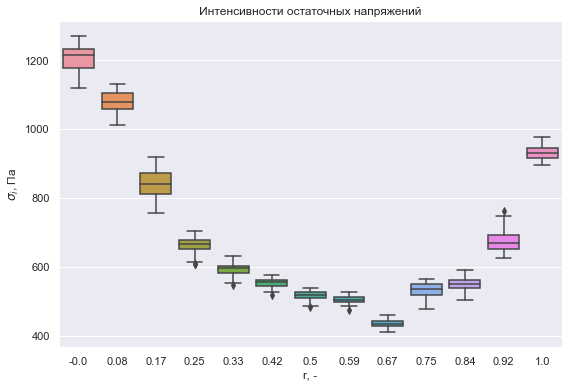

In [32]:
box_plot(x=old[0], y=[old[2][::, 4]], r1=R1[2], name='box_plot_old_str_intens')

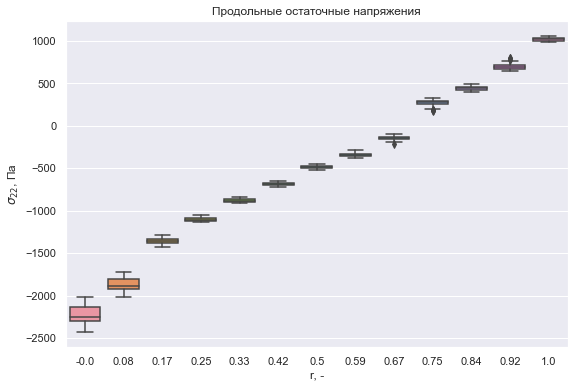

In [33]:
box_plot(x=old[0], y=[old[2][::, 1]], r1=R1[2], name='box_plot_old_str_s22', label='Продольные остаточные напряжения', ylabel='$\sigma_{22}$')

Все интенсивности для разных сеток

In [34]:
experiment_list = ['+2450_1_l0_tri_type.txt',
                   '+2450_1_l0_ad_mesh_freq1_1.txt',
                   '+2450_1_l0_ad_mesh_freq5_1.txt',
                   '+2450_1_l0_ad_mesh_freq10_1.txt',
                   '+2450_1_l0_ad_mesh_freq15_1.txt',
                   '+2450_1_l0_doubled_mesh.txt',
                   '+2450_1_l0_smaller_step.txt']
arrays = [tri, old,
          ad_mesh_freq1,
          ad_mesh_freq5,
          ad_mesh_freq10,
          ad_mesh_freq15,
          doubled_mesh,
          smaller_step]
experiment_labels = ['tri', 'old',
                     'ad_mesh_freq1',
                     'ad_mesh_freq5',
                     'ad_mesh_freq10',
                     'ad_mesh_freq15',
                     'doubled_mesh',
                     'smaller_step']

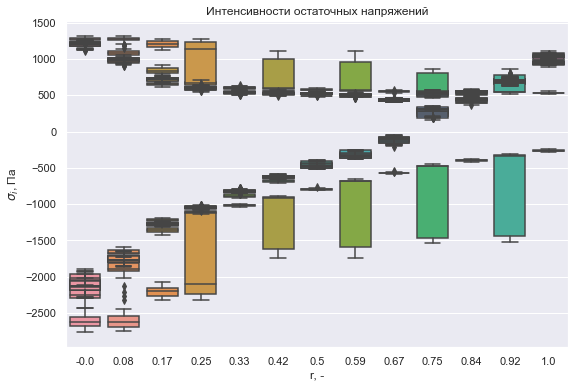

In [35]:
for ind, type in enumerate(arrays[1:]):
    box_plot(x=type[0], y=[type[2][::, 1]], r1=R1[2], name='box_plot_' + experiment_labels[1+ind] +'_str_s22', label='Продольные остаточные напряжения', ylabel='$\sigma_{22}$')
    box_plot(x=type[0], y=[type[2][::, 4]], r1=R1[2], name='box_plot_old_str_intens_'+ experiment_labels[1+ind])

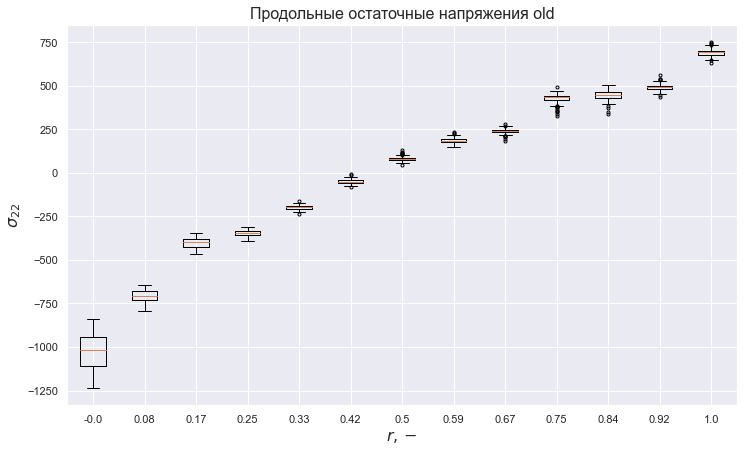

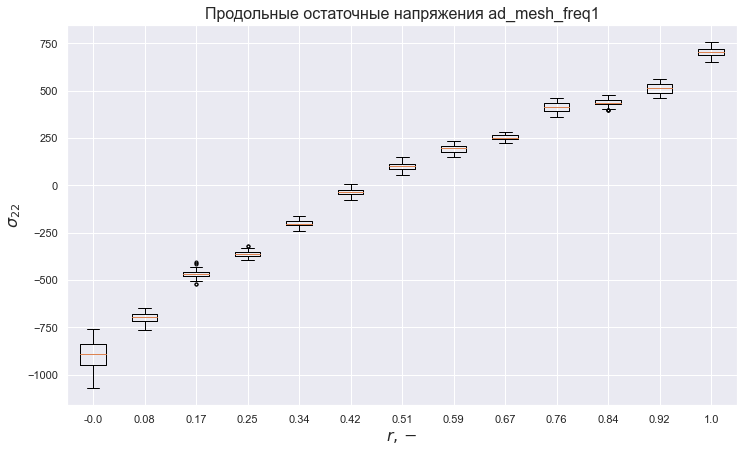

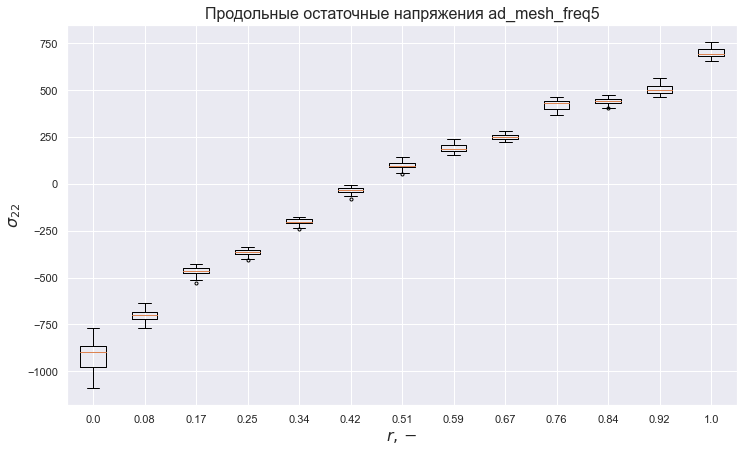

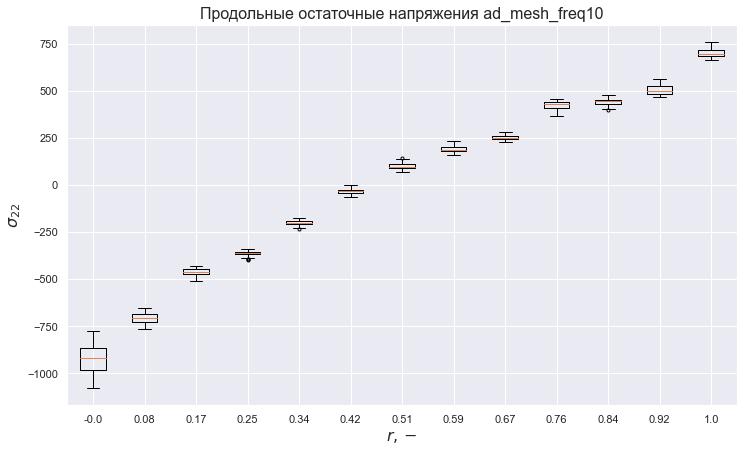

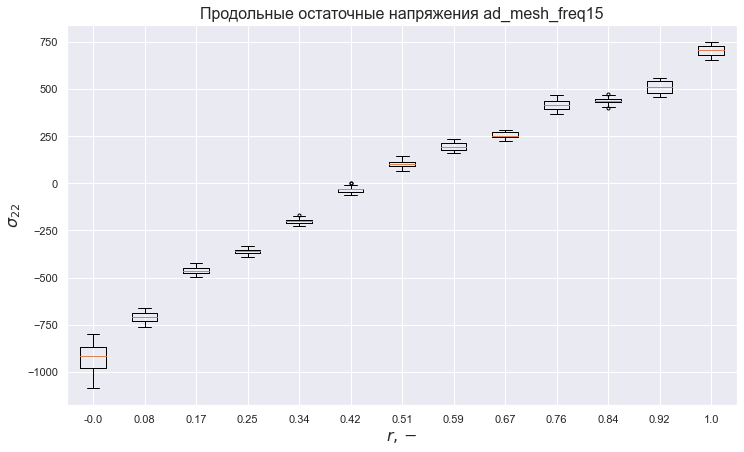

In [36]:
for ind, type in enumerate(arrays[1:6]):
    x, y = sorter(type[0], [type[2][::, 2]])
    y = y[0].reshape((13, 75)).T
    x = average_val_np(x)/R1[2]
    plt.figure(figsize=(12, 7))
    plt.boxplot(x=y, sym='.')
    plt.xticks(np.arange(1, 14), x.round(2), fontsize=11)
    plt.yticks(fontsize=11)
    plt.title('Продольные остаточные напряжения ' + experiment_labels[1+ind], fontsize=16)
    plt.ylabel('$\sigma_{22}$', fontsize=16)
    plt.xlabel('$r, -$', fontsize=16)
    plt.savefig('box_plot_' + experiment_labels[1+ind] + '_str_s22' + 'NEW_PREP_RES_FUNC' + '.png')
    # plt.show()

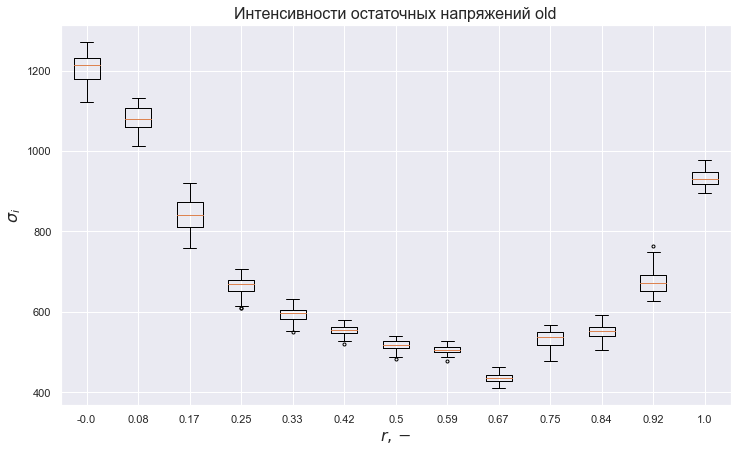

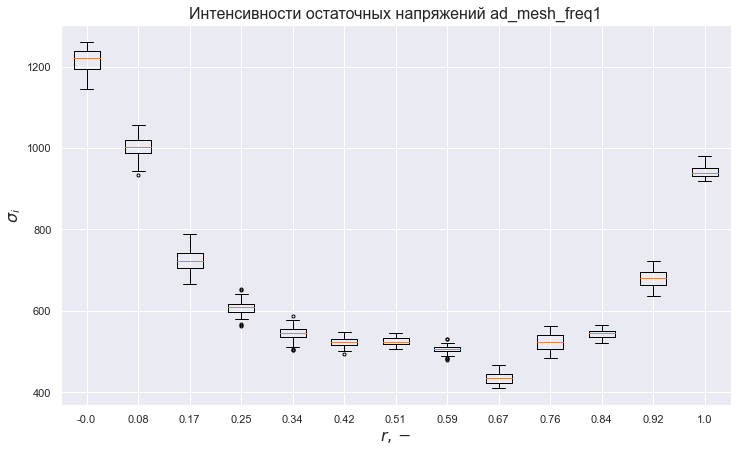

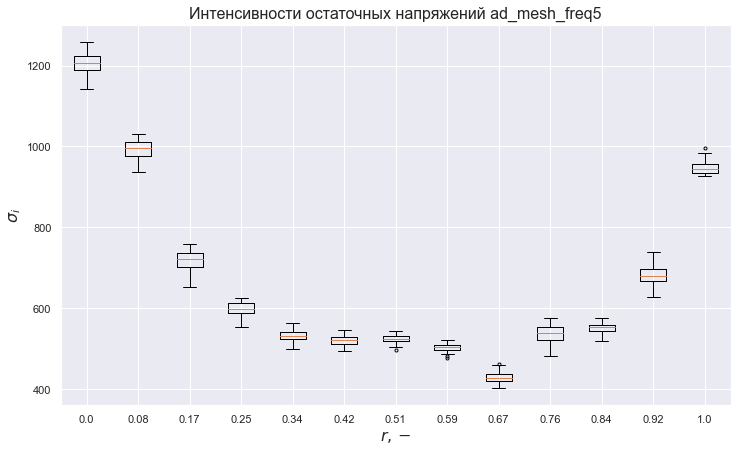

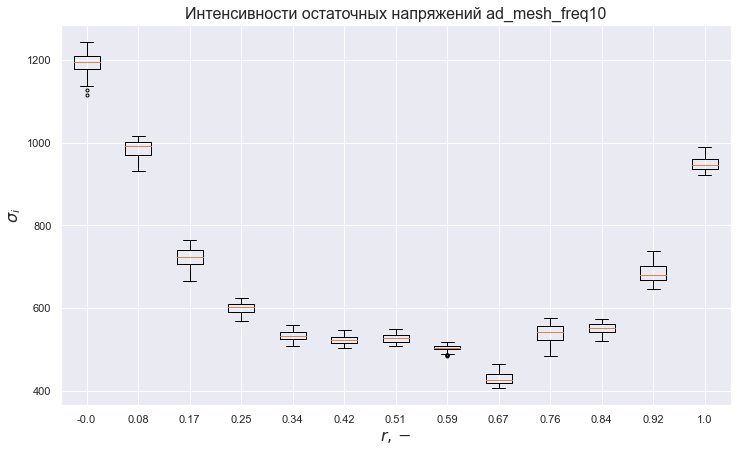

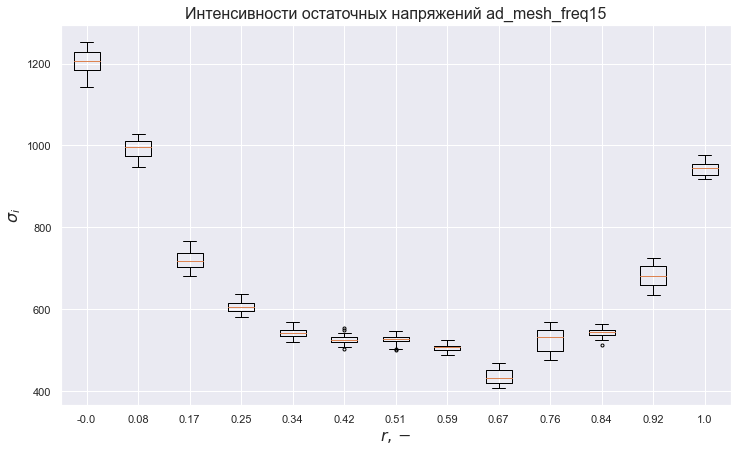

In [37]:
for ind, type in enumerate(arrays[1:6]):
    x, y = sorter(type[0], [type[2][::, 4]])
    y = y[0].reshape((13, 75)).T
    x = average_val_np(x)/R1[2]
    plt.figure(figsize=(12, 7))
    plt.boxplot(x=y, sym='.')
    plt.xticks(np.arange(1, 14), x.round(2), fontsize=11)
    plt.yticks(fontsize=11)
    plt.title('Интенсивности остаточных напряжений ' + experiment_labels[1+ind], fontsize=16)
    plt.ylabel('$\sigma_{i}$', fontsize=16)
    plt.xlabel('$r, -$', fontsize=16)
    plt.savefig('box_plot_' + experiment_labels[1+ind] + '_str_intens.png')
    # plt.show()

In [38]:
def boxplot_plt(preprocessed_data, label_eng, characteristics_idx=2, str_idx=4, radius_idx=2, shape=(13, 75)):

    if str_idx == 4:
        title = 'Интенсивности остаточных '
        ylabel = '_{i}$'
        appendix = '_intens'
    elif str_idx == 2:
        title = 'Продольные остаточные '
        ylabel = '_{22}$'
        appendix = '_22'

    if characteristics_idx == 2:
        ylabel = '$\sigma' + ylabel
        appendix = 'stress' + appendix
        if str_idx == 2:
            title += 'напряжения '
        if str_idx == 4:
            title += 'напряжений '
    elif characteristics_idx == 3:
        ylabel = '$\\varepsilon' + ylabel
        appendix = 'strain' + appendix
        if str_idx == 2:
            title += 'деформации '
        if str_idx == 4:
            title += 'деформаций '

    x, y = sorter(preprocessed_data[0], [preprocessed_data[characteristics_idx][::, str_idx]])
    y = y[0].reshape(shape).T
    x = doubled_average_val_np(x, chunk_size=shape[0]) / R1[radius_idx]
    # print(x.shape)
    plt.figure(figsize=(12, 7))
    plt.boxplot(x=y, sym='.')
    plt.xticks(np.arange(1, shape[0]+1), x.round(2), fontsize=11)
    plt.yticks(fontsize=11)
    plt.title(title + label_eng, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel('$r, -$', fontsize=16)
    plt.savefig('boxplot_plt_' + label_eng + '_' + appendix + '.png')

In [39]:
doubled_mesh_stress = np.delete(doubled_mesh[2], np.s_[-8:-1], axis=0)
doubled_mesh_strain = np.delete(doubled_mesh[3], np.s_[-8:-1], axis=0)
doubled_mesh_x = np.delete(doubled_mesh[0], np.s_[-8:-1], axis=0)
doubled_mesh_y = np.delete(doubled_mesh[1], np.s_[-8:-1], axis=0)

doubled_mesh_preprocessed = [doubled_mesh_x, doubled_mesh_y, doubled_mesh_stress, doubled_mesh_strain]

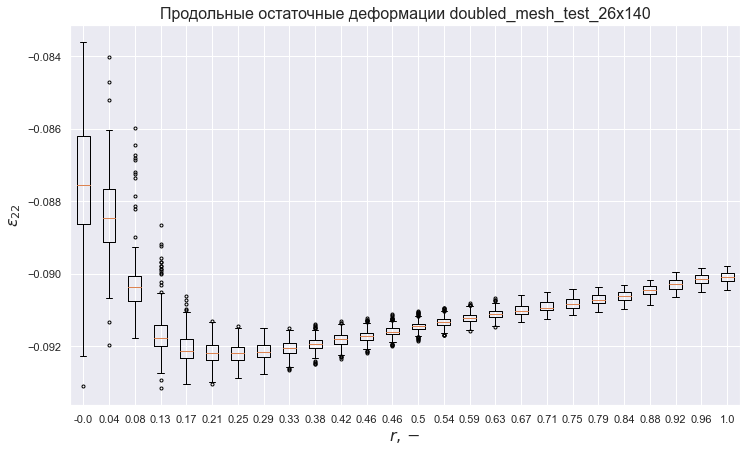

In [40]:
boxplot_plt(doubled_mesh_preprocessed, 'doubled_mesh_test_26x140', characteristics_idx=3, str_idx=2, shape=(26, 140))

In [41]:
def median_extension(preprocessed_data, number_of_columns=25, extension_length=3):
    med_ext = list(preprocessed_data[:])
    for i in range(len(doubled_mesh)):
        m = np.median(med_ext[i][extension_length-number_of_columns:-1], axis=0)
        m = np.tile(m.T, (extension_length, 1))
        if med_ext[i].ndim == 1:
            med_ext[i] = np.reshape(med_ext[i], (len(med_ext[i]), 1))
        med_ext[i] = np.vstack((med_ext[i], m))
    return med_ext

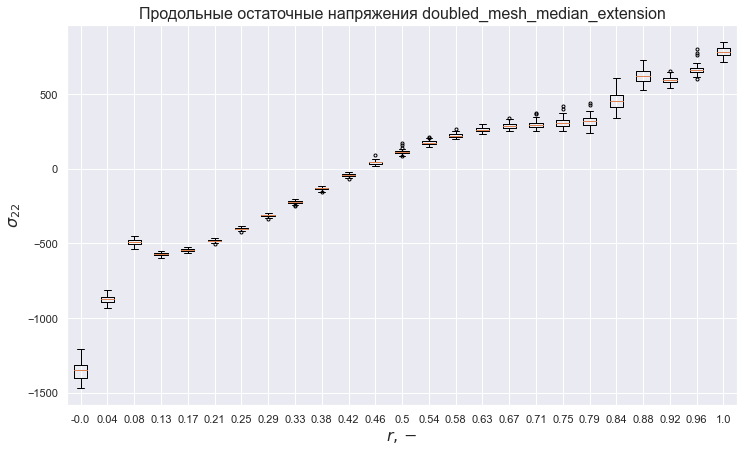

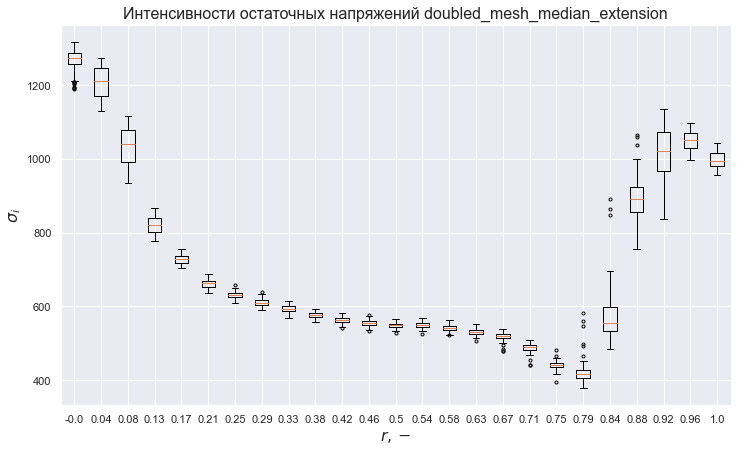

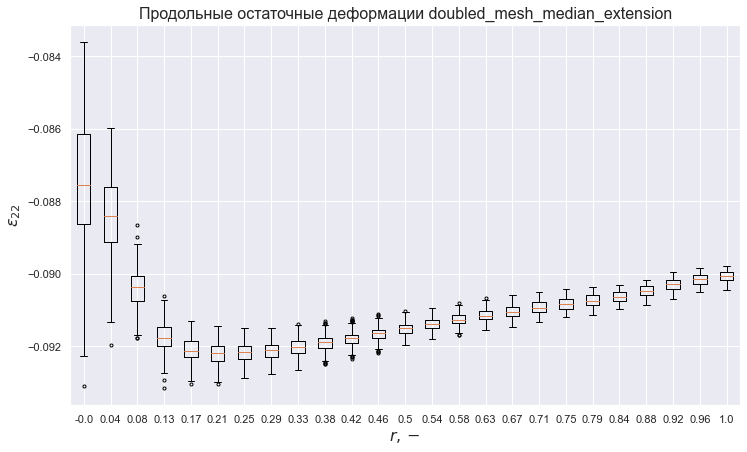

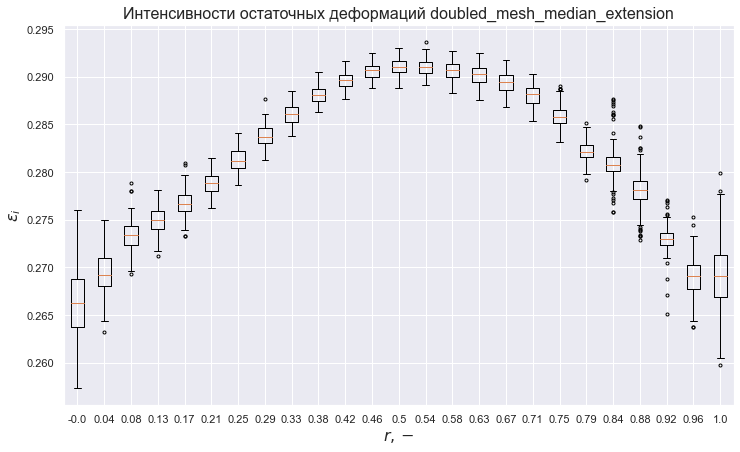

In [42]:
for ch_i in [2, 3]:
    for str_i in [2, 4]:
        boxplot_plt(median_extension(doubled_mesh),
                    'doubled_mesh_median_extension',
                    characteristics_idx=ch_i,
                    str_idx=str_i,
                    shape=(25, 146))

In [43]:
def func11(R, R0, R1, alfa, mu=0.1):
    sina_2 = np.sin(np.deg2rad(alfa))**2
    numer = (1 - 11/12 * (R/R1) * sina_2)
    denom = (1 - (R/R1)**2  * sina_2)
    mean_e = 2 * np.sqrt(numer/denom) * np.log(R0/R1) + mu * (R/R1)**2
    
    return mean_e

<ipython-input-43-9157b1932ee3>:5: RuntimeWarning:

invalid value encountered in sqrt



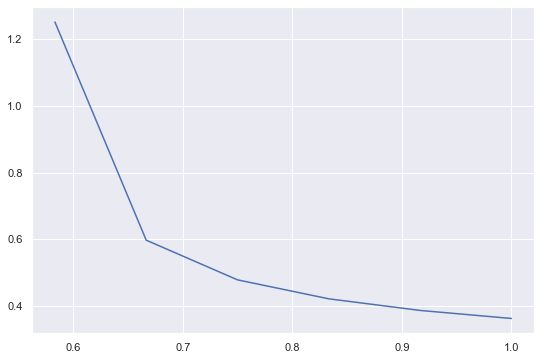

In [99]:
x = np.linspace(0, 1, 13)
R = np.linspace(R0[2], R1[2], 13)
y = func11(R, R0[2], R1[2], 5)
plt.plot(x, y)
# plot_result_strain_avr_v(files_list(['+2450_1_l05_fric_050conical.txt'], di), R1[2], 'our', 'delete_this')

In [48]:
our = preprocessing_res_np(files_list(['+2450_1_l05_fric_050conical.txt'], di)[0])

In [89]:
def plot_compare_strain_avr_v(list_files, R1, labels, name):
    """Строит графики для минимальных, максимальных и средних деформаций для переданных списков в вертикальной ориентации"""
    plt.figure(figsize=(18, 10))
    global colours_
    global markers_
    #f = plt.figure(figsize=(9,6))
    for i in range(0, len(list_files)):

        x_1 = average_val_np(preprocessing_res_np(list_files[i])[0])
        x = np.linspace(0, 1, 13)
        y = func11(x, R0[2], R1, 5)

        for j in range(1, 4):
            plt.subplot(1, 3, j)
            # plt.subplots_adjust(left=0.0, right=0.5, top=0.7, bottom=0.0)

            avr_strain = average_val_np(preprocessing_res_np(list_files[i])[3][::, j - 1])
            #             min_strain = min_val_np(preprocessing_res_np(list_files[i])[3][::,j-1])
            #             max_strain =  max_val_np(preprocessing_res_np(list_files[i])[3][::,j-1])

            plt.plot(x_1 / R1, avr_strain, markers_[i], markersize=9, color=colours_[i], label=labels[i])
            plt.plot(x_1 / R1, y, markers_[i+1], markersize=9, color=colours_[i+1], label=labels[i+1])
            #             plt.plot(x_1/R1, min_strain, '-*', markersize=9, color = colours_[i])
            #             plt.plot(x_1/R1, max_strain, '-.', markersize=9, color = colours_[i])

            if (j == 1):
                plt.ylabel('$ \epsilon_{r}$, -', fontsize=20, fontname='Times New Roman')

            elif (j == 2):
                plt.ylabel('$ \epsilon_{z}$, -', fontsize=20, fontname='Times New Roman')

            elif (j == 3):
                plt.ylabel('$ \epsilon_{\phi}$, -', fontsize=20, fontname='Times New Roman')

            #elif(i==4):
            #   plt.ylabel('$\sigma_{rz}$, MPa ', fontsize=22,fontname='Times New Roman')

            plt.xlim(0, 1.01)
            plt.tick_params(axis='x', length=5, labelsize=10, zorder=15)
            plt.tick_params(axis='y', length=5, labelsize=10, zorder=15)
            plt.xticks(np.arange(0, 1.02, 0.2))

            plt.xlabel(' r, -', fontsize=20, fontname='Times New Roman')
            plt.legend(loc='best')
            #plt.grid(True)

    plt.subplots_adjust(wspace=0.333, hspace=0)
    plt.savefig(name + 'avr_strain_v_' + '.png', dpi=600)
    plt.show()

In [96]:
def compare_avr_strain_intensity(list_files, R1, labels):
    plt.figure(figsize=(13, 9))
    global colours_
    for i in range(0, len(list_files)):
        x = np.linspace(0, 1, 13)
        R = np.linspace(R0[2], R1, 13)
        y = func11(R, R0[2], R1, 5)

        x_1 = average_val_np(preprocessing_res_np(list_files[i])[0])
        avr_strain = average_val_np(preprocessing_res_np(list_files[i])[3][::, 4])
        min_strain = min_val_np(preprocessing_res_np(list_files[i])[3][::, 4])
        max_strain = max_val_np(preprocessing_res_np(list_files[i])[3][::, 4])
        plt.plot(x_1 / R1, avr_strain, '-*', markersize=9, color=colours_[i], label=labels[i])
        plt.plot(x_1 / R1, min_strain, '--', markersize=9, color=colours_[i])
        plt.plot(x_1 / R1, max_strain, '-.', markersize=9, color=colours_[i])
        plt.plot(x_1 / R1, y, markers_[i+1], markersize=9, color=colours_[i+1], label=labels[i+1])


    plt.xlim(0, 1.01)
    plt.tick_params(axis='x', length=10, labelsize=15, zorder=15)
    plt.tick_params(axis='y', length=10, labelsize=15, zorder=15)
    plt.xticks(np.arange(0, 1.02, 0.2))

    plt.ylabel('$\epsilon_{i}$, - ', fontsize=22)  #, fontname='Times New Roman')
    plt.xlabel(' r, -', fontsize=22)  #, fontname='Times New Roman')
    plt.legend(loc='best')
    #path_for_pictures
    plt.savefig('compare_avr_strain_intensity' + str(labels[0]) + '.png', dpi=600)
    plt.show()

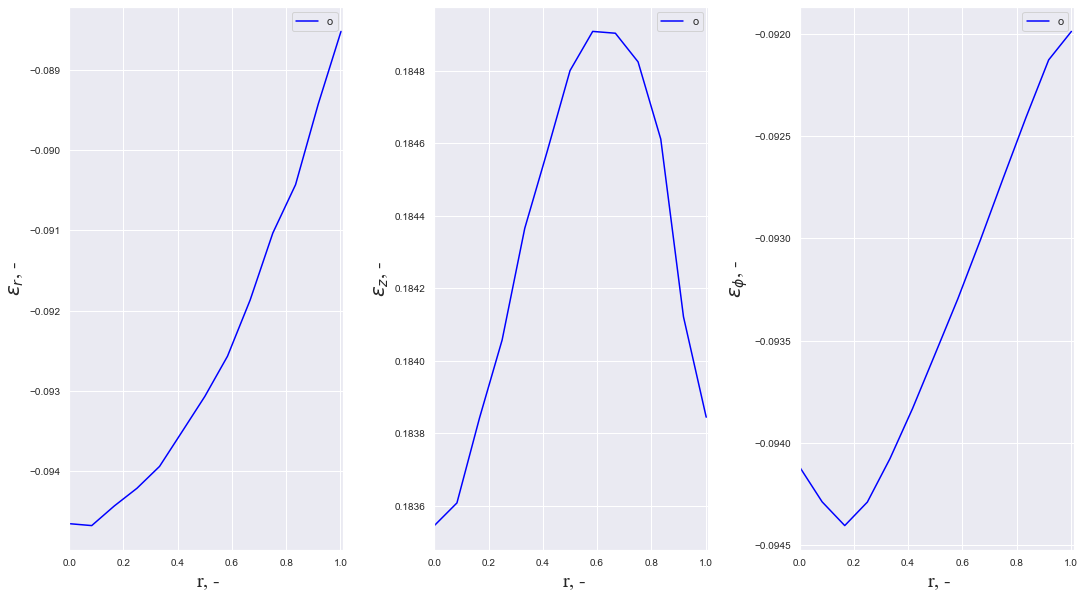

In [81]:
plot_result_strain_avr_v(files_list(['+2450_1_l05_fric_050conical.txt'], di), R1[2], 'our', 'delete_this')

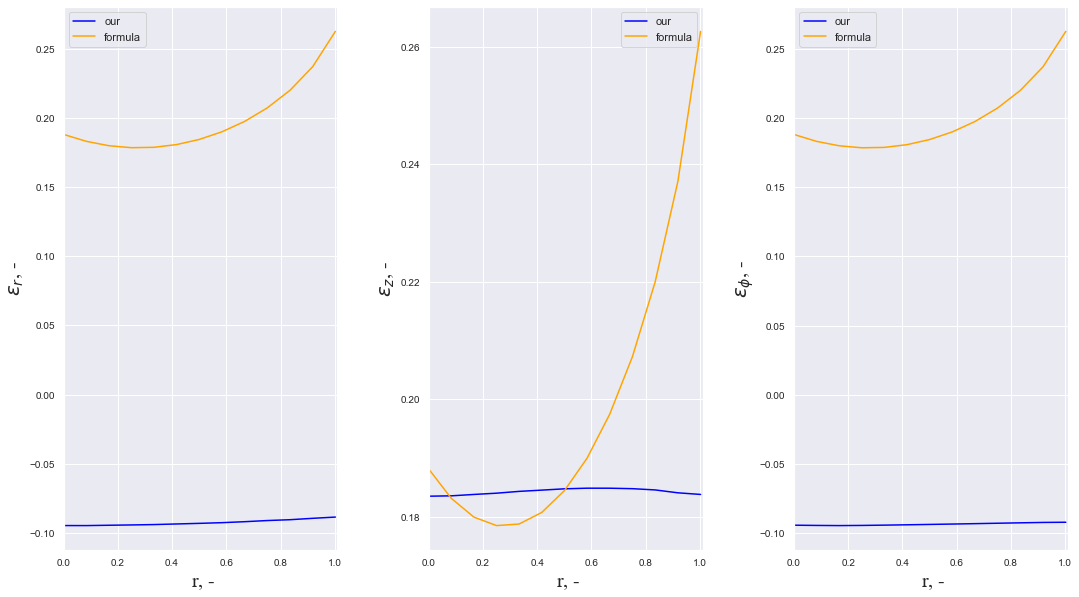

In [90]:
plot_compare_strain_avr_v(files_list(['+2450_1_l05_fric_050conical.txt'], di), R1[2], ['our', 'formula'], 'delete_this')

<ipython-input-43-9157b1932ee3>:5: RuntimeWarning:

invalid value encountered in sqrt



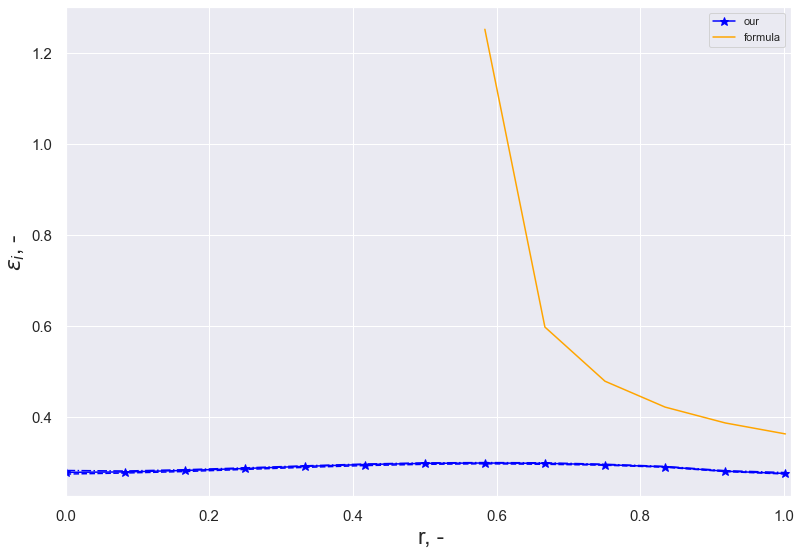

In [97]:
compare_avr_strain_intensity(files_list(['+2450_1_l05_fric_050conical.txt'], di), R1[2], ['our', 'formula'])

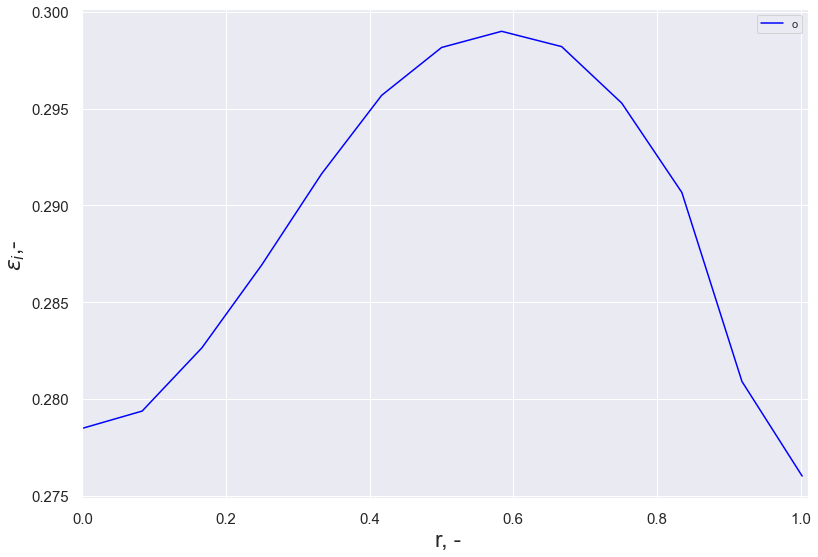

In [78]:
average_strain_intensity_np(files_list(['+2450_1_l05_fric_050conical.txt'], di), R1[2], 'our', 'delete_this')